<a href="https://colab.research.google.com/github/ali3brt/-Ali3brt-s-Machine-Learning-and-Deep-Learning-Projects/blob/main/AI_Dental_Assistance_Object_Detection_3colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### AI Dental Assistance - Object Detection project

# requirement:
# - this should be run in google colab
# - after opening the notebook file,
# change runtime first before upload a file on colab
# - to change runtime: Menu bar -> Runtime -> Change runtime type -> T4 GPU
# - upload Dental_Radiography.zip in where sample_data folder is

# import library
import zipfile
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
# Step 1: Extract the Dataset
# run this on colab
zip_file_path = '/content/Dental_Radiography.zip'
extract_to_path = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)


In [3]:
# Step 2: Explore the Extracted Dataset
# Define paths for the extracted directories
#dental_radiography_path = os.path.join(extract_to_path, 'Dental_Radiography')
#train_path = os.path.join(dental_radiography_path, 'train')
#images_path = os.path.join(train_path, 'images')
#annotations_path = os.path.join(train_path, '_annotations.csv')
#train_images_path = 'bone_fracture_detection/train/images'
train_path = '/content/Dental_Radiography/train'
images_path = '/content/Dental_Radiography/train/images'
annotations_path = '/content/Dental_Radiography/train/_annotations.csv'


In [4]:
# Load the annotations dataframe
annotations_df = pd.read_csv(annotations_path)
annotations_df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,175,116,206,153
1,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Fillings,170,109,189,133
2,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,221,124,257,178
3,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,302,126,329,175
4,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,335,114,360,154


In [5]:
# list of classes
annotations_df['class'].unique().tolist()


['Implant', 'Fillings', 'Impacted Tooth', 'Cavity']

In [6]:
# Step 3: Preprocessing Steps
# Step 3.1: Normalization
# Rescale the features if needed (already handled by ImageDataGenerator rescale)

# Step 3.2: Remove Null Values
# Remove rows with any null values to ensure clean data
annotations_df.dropna(inplace=True)

# Step 3.3: Remove Outliers
# Assuming bounding box coordinates are outliers if outside the image dimensions (e.g., negative or too large)
image_width, image_height = 224, 224  # Assuming all images are resized to 224x224 for VGG16
annotations_df = annotations_df[(annotations_df['xmin'] >= 0) & (annotations_df['ymin'] >= 0) &
                                (annotations_df['xmax'] <= image_width) & (annotations_df['ymax'] <= image_height)]


In [7]:
annotations_df.shape


(3355, 8)

In [8]:
# Step 3.4: Data Augmentation
# Using ImageDataGenerator to augment the images for better model generalization
image_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [9]:
# Step 4: Transfer Learning using VGG16

# Option to train from scratch
# Uncomment the following lines if you want to train from scratch using batch normalization and dropout
# from tensorflow.keras.layers import BatchNormalization
# custom_layers = Flatten()(vgg16_base.output)
# custom_layers = Dense(512, activation='relu')(custom_layers)
# custom_layers = BatchNormalization()(custom_layers)
# custom_layers = Dropout(0.5)(custom_layers)
# predictions = Dense(len(annotations_df['class'].unique()), activation='softmax')(custom_layers)
# model = Model(inputs=vgg16_base.input, outputs=predictions)
# Load the VGG16 model without the top layer (for transfer learning)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the VGG16 base
x = vgg16_base.output
x = Flatten()(x)

# Branch #1: Bounding Box Prediction
bbox_branch = Dense(256, activation='relu')(x)
bbox_branch = Dropout(0.5)(bbox_branch)
bbox_predictions = Dense(4, activation='sigmoid',
                         name='bbox_output')(bbox_branch)  # Output layer with 4 neurons for bounding box

# Branch #2: Class Label Prediction
class_branch = Dense(256, activation='relu')(x)
class_branch = Dropout(0.5)(class_branch)
class_predictions = Dense(len(annotations_df['class'].unique()), activation='softmax',
                          name='class_output')(class_branch)  # Softmax classifier for class labels

# Create the model
model = Model(inputs=vgg16_base.input, outputs=[bbox_predictions, class_predictions])

# Freeze the layers of VGG16 to retain pre-trained features
for layer in vgg16_base.layers:
    layer.trainable = False

# Compile the model for training
model.compile(
    optimizer='adam',
    loss={'bbox_output': 'mse', 'class_output': 'categorical_crossentropy'},
    metrics={'bbox_output': 'mse', 'class_output': 'accuracy'}
)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 27,562,312 (105.14 MB)

 Trainable params: 12,847,624 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Step 5: Split Data for Training, Validation, and Test Sets
# Splitting the annotations dataframe into train, validation, and test sets
train_annotations, temp_annotations = train_test_split(annotations_df, test_size=0.3, random_state=42)
val_annotations, test_annotations = train_test_split(temp_annotations, test_size=0.5, random_state=42)


In [11]:
# Step 6: Track Training Loss and Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

# Directory for storing TensorBoard logs
log_dir = '/content/logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [12]:
# Step 6.1: Create Data Generator Function
# Create a function to generate data from images and annotations
def create_data_generator(annotations, images_path, datagen, batch_size=32):
    def generator():
        for start in range(0, len(annotations), batch_size):
            end = min(start + batch_size, len(annotations))
            batch_annotations = annotations[start:end]
            images = []
            bbox_labels = []
            class_labels = []

            for _, row in batch_annotations.iterrows():
                image_path = os.path.join(images_path, row['filename'])
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                images.append(image)
                bbox_labels.append([row['xmin']/image_width, row['ymin']/image_height,
                                    row['xmax']/image_width, row['ymax']/image_height])
                class_labels.append(row['class'])

            images = np.array(images, dtype='float32') / 255.0
            bbox_labels = np.array(bbox_labels, dtype='float32')
            class_labels = pd.get_dummies(class_labels).reindex(columns=annotations['class'].unique(),
                                                                fill_value=0).values.astype('float32')
            yield images, (bbox_labels, class_labels)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            (
                tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                tf.TensorSpec(shape=(None, len(annotations['class'].unique())), dtype=tf.float32)
            )
        )
    ).prefetch(tf.data.AUTOTUNE)


In [13]:
# Create data generators for training and validation
train_generator = create_data_generator(train_annotations, images_path, image_datagen)
val_generator = create_data_generator(val_annotations, images_path, image_datagen)


In [14]:
# Train the model
epochs = 10 # Reduced epochs for quicker training
history_vgg16 = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_annotations) // 32,
    validation_data=val_generator,
    validation_steps=len(val_annotations) // 32,
    callbacks=[tensorboard_callback]
)


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - bbox_output_loss: 0.1309 - bbox_output_mse: 0.1309 - class_output_accuracy: 0.5391 - class_output_loss: 2.4548 - loss: 2.5857 - val_bbox_output_loss: 0.1221 - val_bbox_output_mse: 0.1221 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.6721 - val_loss: 1.7942
Epoch 2/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 9:36 8s/step - bbox_output_loss: 0.1374 - bbox_output_mse: 0.1374 - class_output_accuracy: 0.7500 - class_output_loss: 0.7217 - loss: 0.8591

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 25s 233ms/step - bbox_output_loss: 0.1374 - bbox_output_mse: 0.1374 - class_output_accuracy: 0.7500 - class_output_loss: 0.7217 - loss: 0.8591 - val_bbox_output_loss: 0.1193 - val_bbox_output_mse: 0.1193 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.5888 - val_loss: 1.7081
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - bbox_output_loss: 0.1264 - bbox_output_mse: 0.1264 - class_output_accuracy: 0.6621 - class_output_loss: 0.9806 - loss: 1.1070 - val_bbox_output_loss: 0.1200 - val_bbox_output_mse: 0.1200 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.9677 - val_loss: 2.0877
Epoch 4/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - bbox_output_loss: 0.1416 - bbox_output_mse: 0.1416 - class_output_accuracy: 0.7500 - class_output_loss: 0.6172 - loss: 0.7588

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - bbox_output_loss: 0.1416 - bbox_output_mse: 0.1416 - class_output_accuracy: 0.7500 - class_output_loss: 0.6172 - loss: 0.7588 - val_bbox_output_loss: 0.1292 - val_bbox_output_mse: 0.1292 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.8981 - val_loss: 2.0273
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - bbox_output_loss: 0.1248 - bbox_output_mse: 0.1248 - class_output_accuracy: 0.6686 - class_output_loss: 0.9091 - loss: 1.0339 - val_bbox_output_loss: 0.1116 - val_bbox_output_mse: 0.1116 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.8984 - val_loss: 2.0100
Epoch 6/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - bbox_output_loss: 0.1600 - bbox_output_mse: 0.1600 - class_output_accuracy: 0.7500 - class_output_loss: 0.7286 - loss: 0.8886

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - bbox_output_loss: 0.1600 - bbox_output_mse: 0.1600 - class_output_accuracy: 0.7500 - class_output_loss: 0.7286 - loss: 0.8886 - val_bbox_output_loss: 0.1202 - val_bbox_output_mse: 0.1202 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.8334 - val_loss: 1.9536
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - bbox_output_loss: 0.1253 - bbox_output_mse: 0.1253 - class_output_accuracy: 0.6717 - class_output_loss: 0.8785 - loss: 1.0038 - val_bbox_output_loss: 0.1147 - val_bbox_output_mse: 0.1147 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 2.2361 - val_loss: 2.3508
Epoch 8/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - bbox_output_loss: 0.1155 - bbox_output_mse: 0.1155 - class_output_accuracy: 0.7500 - class_output_loss: 0.6144 - loss: 0.7299

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - bbox_output_loss: 0.1155 - bbox_output_mse: 0.1155 - class_output_accuracy: 0.7500 - class_output_loss: 0.6144 - loss: 0.7299 - val_bbox_output_loss: 0.1263 - val_bbox_output_mse: 0.1263 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 2.1370 - val_loss: 2.2633
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 242ms/step - bbox_output_loss: 0.1209 - bbox_output_mse: 0.1209 - class_output_accuracy: 0.6778 - class_output_loss: 0.8697 - loss: 0.9906 - val_bbox_output_loss: 0.1135 - val_bbox_output_mse: 0.1135 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.8489 - val_loss: 1.9624
Epoch 10/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - bbox_output_loss: 0.1118 - bbox_output_mse: 0.1118 - class_output_accuracy: 0.6667 - class_output_loss: 0.7186 - loss: 0.8303

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - bbox_output_loss: 0.1118 - bbox_output_mse: 0.1118 - class_output_accuracy: 0.6667 - class_output_loss: 0.7186 - loss: 0.8303 - val_bbox_output_loss: 0.1164 - val_bbox_output_mse: 0.1164 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.6941 - val_loss: 1.8105


In [15]:
# show train accuracy
train_accuracy = history_vgg16.history['class_output_accuracy'][-1]
print(f"Train accuracy: {train_accuracy:.3f}")

Train accuracy: 0.667


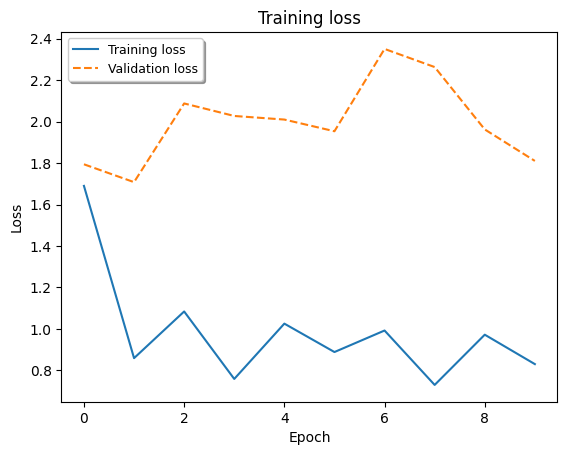

In [16]:
# show train and validation loss
plt.plot(history_vgg16.history['loss'], label="Training loss")
plt.plot(history_vgg16.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


In [17]:
# Step 7: Evaluate the Model on Test Data
# Creating a test data generator
test_generator = create_data_generator(test_annotations, images_path, image_datagen)

# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=len(test_annotations) // 32)
print(f'Test Results: {test_results}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - bbox_output_loss: 0.1191 - bbox_output_mse: 0.1191 - class_output_accuracy: 0.0758 - class_output_loss: 1.6487 - loss: 1.7678
Test Results: [1.772697925567627, 0.11920039355754852, 1.653497576713562, 0.11920039355754852, 0.0833333358168602]


In [18]:
# Step 8: Apply Model Prediction
# Sample prediction
sample_image_filename = test_annotations['filename'].iloc[0]
sample_image = cv2.imread(os.path.join(images_path, sample_image_filename))
sample_image_resized = cv2.resize(sample_image, (224, 224)) / 255.0
sample_image_resized = np.expand_dims(sample_image_resized, axis=0)
pred_bbox, pred_class = model.predict(sample_image_resized)
print(f'Predicted Bounding Box: {pred_bbox}')
print(f'Predicted Class: {pred_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Bounding Box: [[1.000000e+00 4.321115e-13 1.000000e+00 1.000000e+00]]
Predicted Class: [[0.2318784  0.34111616 0.22986858 0.19713688]]


In [19]:
# Step 9: Interpret and Report Results
# Details of hardware used
device_info = {
    'device': 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU',
    'memory': 'N/A'  # Add specific memory details if available
}
print(f'Device Info: {device_info}')


Device Info: {'device': 'GPU', 'memory': 'N/A'}


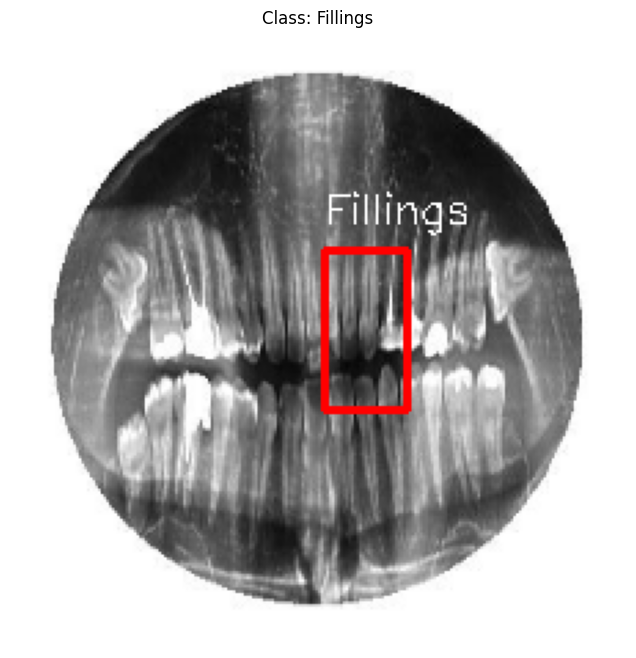

In [20]:
# Step 10: Visualize a Sample Image with Annotations
def visualize_sample_image(image_filename, annotations_df, images_path):
    # Load the image
    image_path = os.path.join(images_path, image_filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (224, 224))

    # Get annotation details for the image
    annotation = annotations_df[annotations_df['filename'] == image_filename].iloc[0]
    xmin, ymin, xmax, ymax = (
        int(annotation['xmin']),
        int(annotation['ymin']),
        int(annotation['xmax']),
        int(annotation['ymax'])
    )
    label = annotation['class']

    # Draw the bounding box and label on the image
    image_with_annotations = image_resized.copy()
    cv2.rectangle(
        image_with_annotations,
        (xmin, ymin),
        (xmax, ymax),
        color=(255, 0, 0),  # Red color for the bounding box
        thickness=2
    )
    cv2.putText(
        image_with_annotations,
        label,
        (xmin, ymin - 10),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.5,
        color=(255, 255, 255),  # White color for the label text
        thickness=1
    )

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_annotations)
    plt.axis('off')
    plt.title(f"Class: {label}")
    plt.show()

# Visualize a sample image with annotations
sample_image_filename = test_annotations['filename'].iloc[0]
visualize_sample_image(sample_image_filename, test_annotations, images_path)


In [21]:

### Other Model comparison


In [22]:
# using EfficientNet_V2_S

# Transfer Learning using EfficientNet_V2_S
from tensorflow.keras.applications import EfficientNetV2S
effNetV2S_base = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the VGG16 base
x = effNetV2S_base.output
x = Flatten()(x)

# Branch #1: Bounding Box Prediction
bbox_branch = Dense(256, activation='relu')(x)
bbox_branch = Dropout(0.5)(bbox_branch)
bbox_predictions = Dense(4, activation='sigmoid',
                         name='bbox_output')(bbox_branch)  # Output layer with 4 neurons for bounding box

# Branch #2: Class Label Prediction
class_branch = Dense(256, activation='relu')(x)
class_branch = Dropout(0.5)(class_branch)
class_predictions = Dense(len(annotations_df['class'].unique()), activation='softmax',
                          name='class_output')(class_branch)  # Softmax classifier for class labels

# Create the model
model02 = Model(inputs=effNetV2S_base.input, outputs=[bbox_predictions, class_predictions])

# Freeze the layers of VGG16 to retain pre-trained features
for layer in effNetV2S_base.layers:
    layer.trainable = False

# Compile the model for training
model02.compile(
    optimizer='adam',
    loss={'bbox_output': 'mse', 'class_output': 'categorical_crossentropy'},
    metrics={'bbox_output': 'mse', 'class_output': 'accuracy'}
)
model02.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 52,446,568 (200.07 MB)

 Trainable params: 32,115,208 (122.51 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [23]:
# EfficientNet_V2_S: Train the model

epochs = 10 # Reduced epochs for quicker training
history_effNetV2S = model02.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_annotations) // 32,
    validation_data=val_generator,
    validation_steps=len(val_annotations) // 32
)


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 74s 298ms/step - bbox_output_loss: 0.1357 - bbox_output_mse: 0.1357 - class_output_accuracy: 0.5236 - class_output_loss: 9.6435 - loss: 9.7791 - val_bbox_output_loss: 0.1258 - val_bbox_output_mse: 0.1258 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.4277 - val_loss: 1.5535
Epoch 2/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 32:14 27s/step - bbox_output_loss: 0.1344 - bbox_output_mse: 0.1344 - class_output_accuracy: 0.6667 - class_output_loss: 1.0487 - loss: 1.1832

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - bbox_output_loss: 0.1344 - bbox_output_mse: 0.1344 - class_output_accuracy: 0.6667 - class_output_loss: 1.0487 - loss: 1.1832 - val_bbox_output_loss: 0.1326 - val_bbox_output_mse: 0.1326 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.4482 - val_loss: 1.5808
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - bbox_output_loss: 0.1298 - bbox_output_mse: 0.1298 - class_output_accuracy: 0.6532 - class_output_loss: 1.1205 - loss: 1.2504 - val_bbox_output_loss: 0.1258 - val_bbox_output_mse: 0.1258 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.4986 - val_loss: 1.6244
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bbox_output_loss: 0.1344 - bbox_output_mse: 0.1344 - class_output_accuracy: 0.7500 - class_output_loss: 1.0134 - loss: 1.1478 - val_bbox_output_loss: 0.1326 - val_bbox_output_mse: 0.1326 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.4705 - val_loss: 1.6031
Epoch 5/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - bbox_output_loss: 0.1297 - bbox_output_mse: 0.1297 - class_output_accuracy: 0.6649 - class_output_loss: 1.1203 - loss: 1.2501 - val_bbox_output_loss: 0.1258 - val_bbox_output_mse: 0.1258 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.6290 - val_loss: 1.7548
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bbox_output_loss: 0.1344 - bbox_output_mse: 0.1344 - class_output_accuracy: 0.7500 - class_output_loss: 0.9226 - loss: 1.0570 - val_bbox_output_loss: 0.1326 - val_bbox_output_mse: 0.1326 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.6111 - val_loss: 1.7437
Epoch 7/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - bbox_output_loss: 0.1297 - bbox_output_mse: 0.1297 - class_output_accuracy: 0.6634 - class_output_loss: 1.1424 - loss: 1.2720 - val_bbox_output_loss: 0.1258 - val_bbox_output_mse: 0.1258 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.6094 - val_loss: 1.7352
Epoch 8/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - bbox_output_loss: 0.1344 - bbox_output_mse: 0.1344 - class_output_accuracy: 0.7500 - class_output_loss: 1.1063 - loss: 1.2408

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - bbox_output_loss: 0.1344 - bbox_output_mse: 0.1344 - class_output_accuracy: 0.7500 - class_output_loss: 1.1063 - loss: 1.2408 - val_bbox_output_loss: 0.1326 - val_bbox_output_mse: 0.1326 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.5914 - val_loss: 1.7241
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - bbox_output_loss: 0.1300 - bbox_output_mse: 0.1300 - class_output_accuracy: 0.6724 - class_output_loss: 1.0940 - loss: 1.2240 - val_bbox_output_loss: 0.1258 - val_bbox_output_mse: 0.1258 - val_class_output_accuracy: 0.0771 - val_class_output_loss: 1.6261 - val_loss: 1.7519
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bbox_output_loss: 0.1344 - bbox_output_mse: 0.1344 - class_output_accuracy: 0.7500 - class_output_loss: 1.0572 - loss: 1.1916 - val_bbox_output_loss: 0.1326 - val_bbox_output_mse: 0.1326 - val_class_output_accuracy: 0.0870 - val_class_output_loss: 1.6027 - val_loss: 1.7353


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [24]:
# EfficientNet_V2_S: show train accuracy

train_accuracy = history_effNetV2S.history['class_output_accuracy'][-1]
print(f"Train accuracy: {train_accuracy:.3f}")


Train accuracy: 0.750


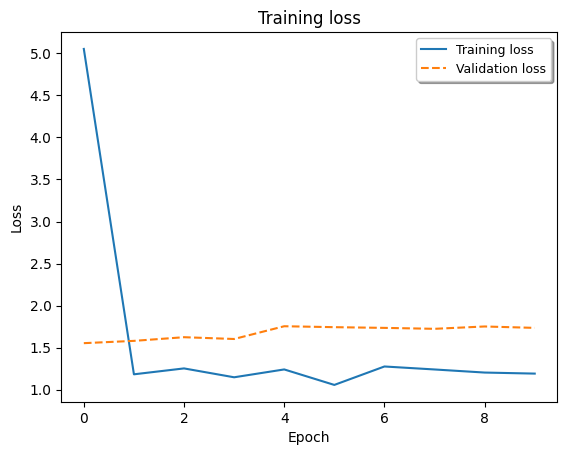

In [25]:
# EfficientNet_V2_S: show train and validation loss

plt.plot(history_effNetV2S.history['loss'], label="Training loss")
plt.plot(history_effNetV2S.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


In [26]:
# EfficientNet_V2_S: Evaluate the Model on Test Data

# Creating a test data generator
test_generator = create_data_generator(test_annotations, images_path, image_datagen)

# Evaluate the model on the test set
test_results = model02.evaluate(test_generator, steps=len(test_annotations) // 32)
print(f'Test Results: {test_results}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - bbox_output_loss: 0.1318 - bbox_output_mse: 0.1318 - class_output_accuracy: 0.0758 - class_output_loss: 1.6142 - loss: 1.7459
Test Results: [1.7376757860183716, 0.13224810361862183, 1.6054273843765259, 0.13224810361862183, 0.0833333358168602]


In [27]:
# EfficientNet_V2_S: Model Prediction function

# get list of classes
class_list = test_annotations['class'].unique().tolist()

# Visualize a test Image with Annotations function
def visualize_test_image(image_filename, images_path, bbox_list, pred_class_list):
    # Load the image
    image_path = os.path.join(images_path, image_filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (224, 224))

    # Get annotation details for the image
    #annotation = annotations_df[annotations_df['filename'] == image_filename].iloc[0]
    xmin, ymin, xmax, ymax = (
        int(bbox_list[0] * 255),
        int(bbox_list[1] * 255),
        int(bbox_list[2] * 255),
        int(bbox_list[3] * 255)
    )
    pred_class_index = pred_class_list.index(0)
    label = class_list[pred_class_index]

    # Draw the bounding box and label on the image
    image_with_annotations = image_resized.copy()
    cv2.rectangle(
        image_with_annotations,
        (xmin, ymin),
        (xmax, ymax),
        color=(255, 0, 0),  # Red color for the bounding box
        thickness=2
    )
    cv2.putText(
        image_with_annotations,
        label,
        (xmin, ymin - 10),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.5,
        color=(255, 0, 0),  # Red color for the label text
        thickness=1
    )

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_annotations)
    plt.axis('off')
    plt.title(f"Class: {label}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


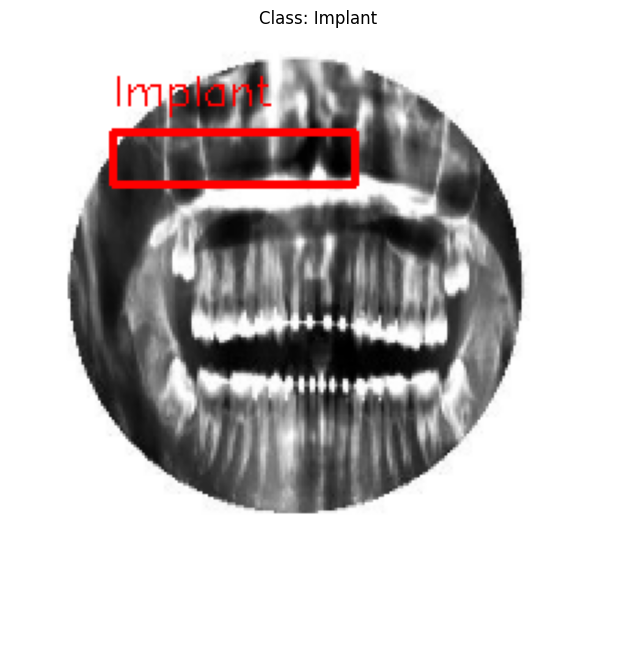

In [28]:
# EfficientNet_V2_S: Appy Model Prediction

# get test image
pred02_image_filename = test_annotations['filename'].iloc[2]
sample_image = cv2.imread(os.path.join(images_path, pred02_image_filename))
sample_image_resized = cv2.resize(sample_image, (224, 224)) / 255.0
sample_image_resized = np.expand_dims(sample_image_resized, axis=0)

# predict test image
pred02_class, pred02_bbox = model02.predict(sample_image_resized)
pred02_class_list = pred02_class[0].tolist()
pred02_class_list = pred02_class_list[::-1]
pred02_bbox_list = pred02_bbox[0].tolist()
pred02_bbox_list = pred02_bbox_list[::-1]

# Visualize prediction
visualize_test_image(pred02_image_filename, images_path, pred02_bbox_list, pred02_class_list)


In [30]:
import pandas as pd

# Load the annotations CSV
df = pd.read_csv('/content/Dental_Radiography/train/_annotations.csv')  # Replace with your actual path

# Preview the first few rows to understand its structure
print(df.head())


                                           filename  width  height     class  \
0  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
1  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256  Fillings   
2  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
3  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
4  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   

   xmin  ymin  xmax  ymax  
0   175   116   206   153  
1   170   109   189   133  
2   221   124   257   178  
3   302   126   329   175  
4   335   114   360   154  


In [43]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step 1: Load your CSV data
csv_path = '/content/Dental_Radiography/train/train_labels_with_problems.csv'
df = pd.read_csv(csv_path)

# Step 2: Check the column names to identify image paths and target labels
print("Column Names:", df.columns)

# Step 3: Set the target column and the image path column
target_column = 'label'  # This is the target class for each sample
image_column = 'filename'  # This is the column containing image paths

def load_and_process_images(image_paths, image_size=(128, 128)):
    image_arrays = []
    for path in image_paths:
        # Construct the full path to the image
        full_path = os.path.join('/content/Dental_Radiography/train/images', path)  # Update with correct base directory
        print(f"Attempting to load image from: {full_path}")  # Debug: print the full path to ensure it is correct

        if not os.path.exists(full_path):
            print(f"Image path does not exist: {full_path}")
            continue

        try:
            img = Image.open(full_path)
            img = img.resize(image_size)  # Resize image to a fixed size
            img_array = np.array(img).flatten()  # Flatten the image into a 1D array
            image_arrays.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            continue

    return np.array(image_arrays)

# Load images again with additional debugging
X_image = load_and_process_images(df[image_column])

# Check how many images were loaded successfully
print(f"Loaded {len(X_image)} images out of {len(df[image_column])}")


# Step 5: Load the images
image_paths = df[image_column]
X_image = load_and_process_images(image_paths)

# Ensure we have the correct number of samples
print(f"Loaded {len(X_image)} images out of {len(image_paths)}")

# Step 6: Extract target labels
y = df[target_column]

# Verify if lengths are consistent
if len(X_image) == 0:
    raise ValueError("No images were loaded. Please check the image paths and ensure images are available in the specified directory.")

if len(X_image) != len(y):
    raise ValueError(f"Inconsistent number of samples: X has {len(X_image)}, while y has {len(y)}.")

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_image, y[:len(X_image)], test_size=0.2, random_state=42)

# Step 8: Create a pipeline with a scaler and a classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Standardize the data
    ('classifier', RandomForestClassifier())  # Step 2: Train a RandomForestClassifier
])

# Step 9: Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Step 10: Make predictions and evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Streaming output truncated to the last 5000 lines.
Attempting to load image from: /content/Dental_Radiography/train/images/0635_jpg.rf.71bc4660639c80d309043774a629d365.jpg
Attempting to load image from: /content/Dental_Radiography/train/images/0635_jpg.rf.71bc4660639c80d309043774a629d365.jpg
Attempting to load image from: /content/Dental_Radiography/train/images/0635_jpg.rf.71bc4660639c80d309043774a629d365.jpg
Attempting to load image from: /content/Dental_Radiography/train/images/0635_jpg.rf.71bc4660639c80d309043774a629d365.jpg
Attempting to load image from: /content/Dental_Radiography/train/images/0363_jpg.rf.77aa662081f0582a8d18475f9ffebe1a.jpg
Attempting to load image from: /content/Dental_Radiography/train/images/0363_jpg.rf.77aa662081f0582a8d18475f9ffebe1a.jpg
Attempting to load image from: /content/Dental_Radiography/train/images/0363_jpg.rf.77aa662081f0582a8d18475f9ffebe1a.jpg
Attempting to load image from: /content/Dental_Radiography/train/images/0363_jpg.rf.77aa662081f0582a8d